In [20]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


In [17]:
# Loading the dataset
df = pd.read_csv('K-12 Homicide Feb 23.csv')
df.set_index('ID', inplace=True) # Making sure the column 'ID' is not included as a model variable

# Filling numerical columns with the median
numerical_cols = df.select_dtypes(include=[np.number]).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# Filling categorical columns with the mode
categorical_cols = df.select_dtypes(include=[object]).columns
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

# Encoding Categorical Variables
df_encoded = pd.get_dummies(df, drop_first=True)

# Defining Response Variable
X = df_encoded.drop('Victims_Killed', axis=1)
y = df_encoded['Victims_Killed']

# Train/Validation/Test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Output dataset shapes
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")


Training set: (198, 387), (198,)
Validation set: (66, 387), (66,)
Test set: (67, 387), (67,)


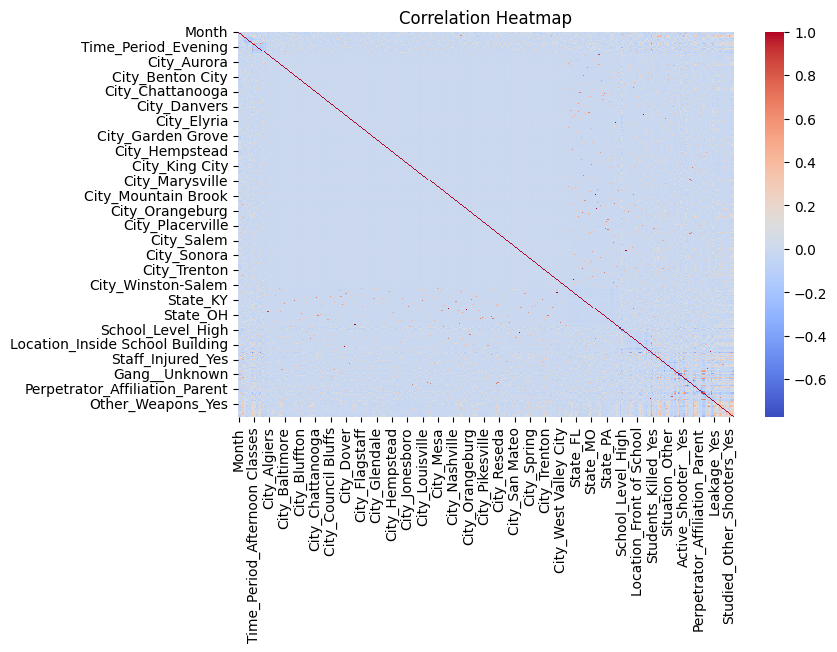

In [6]:
# Correlation heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(df_encoded.corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

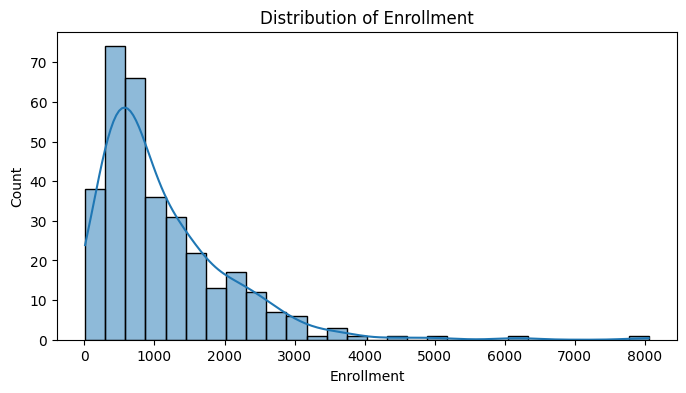

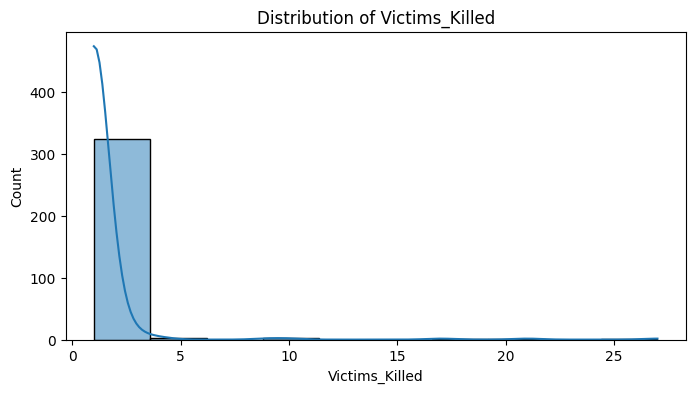

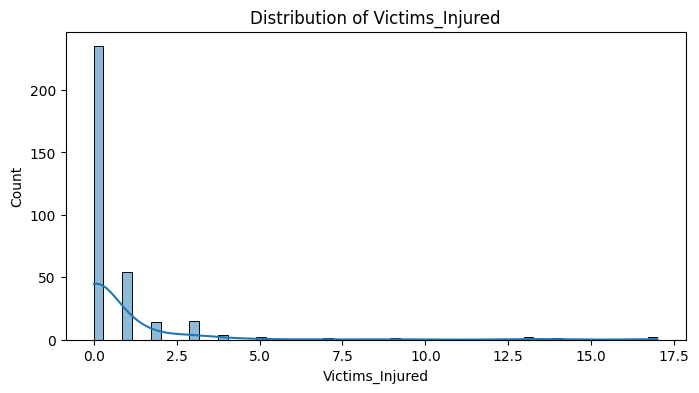

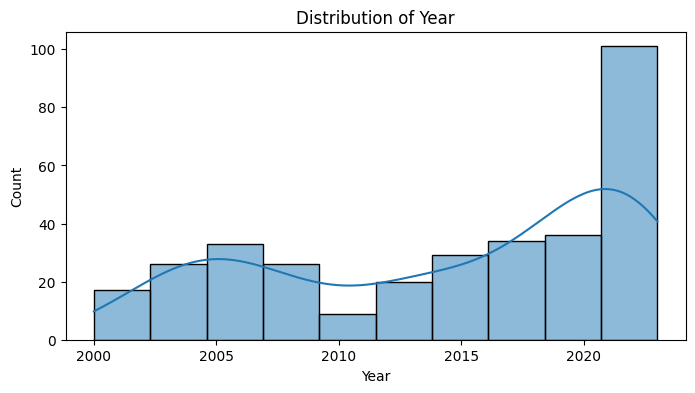

In [7]:
# Distribution plots for key numerical features
numerical_features = ['Enrollment', 'Victims_Killed', 'Victims_Injured', 'Year']
for feature in numerical_features:
  plt.figure(figsize=(8, 4))
  sns.histplot(df[feature], kde=True)
  plt.title(f'Distribution of {feature}')
  plt.show()


In [21]:
# Evaluation metricss
def evaluate_model(y_true, y_pred):
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_true, y_pred)
  mspe = np.mean(np.square((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
  return {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MSPE': mspe}

In [22]:
# Hyperparameter grid to find optimal hyperparameters
configs = [
  {'layers': [64], 'activation': 'relu', 'lr': 0.001},
  {'layers': [64, 32], 'activation': 'relu', 'lr': 0.001},
  {'layers': [128, 64], 'activation': 'relu', 'lr': 0.001},
  {'layers': [64], 'activation': 'tanh', 'lr': 0.001},
  {'layers': [64, 32], 'activation': 'tanh', 'lr': 0.01},
]

In [23]:
# Training loop to determine hyperparameters
results = []
for config in configs:
  model = Sequential()
  model.add(Dense(config['layers'][0], input_dim=X_train.shape[1], activation=config['activation']))
  for units in config['layers'][1:]:
    model.add(Dense(units, activation=config['activation']))
  model.add(Dense(1, activation='linear'))

  model.compile(optimizer=Adam(learning_rate=config['lr']), loss='mse')
  model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

  val_preds = model.predict(X_val).flatten()
  metrics = evaluate_model(y_val.values, val_preds)
  results.append((config, metrics))
  print(f"Config: {config}, Metrics: {metrics}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Config: {'layers': [64], 'activation': 'relu', 'lr': 0.001}, Metrics: {'MAE': 0.8916343450546265, 'RMSE': np.float64(1.268196930629022), 'R2': 0.28599095344543457, 'MSPE': np.float64(94.07651469553943)}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Config: {'layers': [64, 32], 'activation': 'relu', 'lr': 0.001}, Metrics: {'MAE': 0.634003758430481, 'RMSE': np.float64(0.857515959910906), 'R2': 0.6735514402389526, 'MSPE': np.float64(48.26476825952217)}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Config: {'layers': [128, 64], 'activation': 'relu', 'lr': 0.001}, Metrics: {'MAE': 0.706934928894043, 'RMSE': np.float64(1.1421995921610306), 'R2': 0.4208189845085144, 'MSPE': np.float64(49.63093950479219)}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Config: {'layers': [64], 'activation': 'tanh', 'lr': 0.001}, Metrics: {'MAE': 1.5328049659729004, 'RMSE': np.float64(2.007048346423267), 'R2': -0.788323163986206, 'MSPE': np.float64(338.84199649782244)}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Config: {'layers': [64, 32], 'activation': 'tanh', 'lr': 0.01}, Metrics: {'MAE': 2.3830347061157227, 'RMSE': np.float64(3.0577985526396914), 'R2': -3.1509552001953125, 'MSPE': np.float64(844.4907274475923)}


In [24]:
# Finding the best configuration
best_config = min(results, key=lambda x: x[1]['MSPE'])
print("\nBest Configuration:", best_config[0])
print("Validation Metrics:", best_config[1])


Best Configuration: {'layers': [64, 32], 'activation': 'relu', 'lr': 0.001}
Validation Metrics: {'MAE': 0.634003758430481, 'RMSE': np.float64(0.857515959910906), 'R2': 0.6735514402389526, 'MSPE': np.float64(48.26476825952217)}


In [25]:
# Re-training the best model on full training + validation set
X_full_train = np.vstack((X_train, X_val))
y_full_train = np.concatenate((y_train, y_val))

model = Sequential()
model.add(Dense(best_config[0]['layers'][0], input_dim=X_full_train.shape[1], activation=best_config[0]['activation']))
for units in best_config[0]['layers'][1:]:
  model.add(Dense(units, activation=best_config[0]['activation']))
model.add(Dense(1, activation='linear'))

model.compile(optimizer=Adam(learning_rate=best_config[0]['lr']), loss='mse')
model.fit(X_full_train, y_full_train, epochs=50, batch_size=32, verbose=0)

test_preds = model.predict(X_test).flatten()
test_metrics = evaluate_model(y_test.values, test_preds)
print("Test Metrics:", test_metrics)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Test Metrics: {'MAE': 0.8031190037727356, 'RMSE': np.float64(2.78290028848601), 'R2': 0.2240949273109436, 'MSPE': np.float64(37.28847696634981)}


Retesting after removing variables that are multicollinear (VIF > 5).

In [26]:
# Loading the dataset
df = pd.read_csv('K-12 Homicide VIF.csv')
df.set_index('ID', inplace=True) # Making sure the column 'ID' is not included as a model variable

# Filling numerical columns with the median
numerical_cols = df.select_dtypes(include=[np.number]).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# Filling categorical columns with the mode
categorical_cols = df.select_dtypes(include=[object]).columns
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

# Encoding Categorical Variables
df_encoded = pd.get_dummies(df, drop_first=True)

# Defining Response Variable
X = df_encoded.drop('Victims_Killed', axis=1)
y = df_encoded['Victims_Killed']

# Train/Validation/Test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Output dataset shapes
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")


Training set: (198, 45), (198,)
Validation set: (66, 45), (66,)
Test set: (67, 45), (67,)


In [32]:
# Evaluation metricss
def evaluate_model(y_true, y_pred):
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_true, y_pred)
  mspe = np.mean(np.square((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
  return {'MAE': mae, 'R2': r2, 'MSPE': mspe}

In [33]:
# Hyperparameter grid to find optimal hyperparameters
configs = [
  {'layers': [64], 'activation': 'relu', 'lr': 0.001},
  {'layers': [64, 32], 'activation': 'relu', 'lr': 0.001},
  {'layers': [128, 64], 'activation': 'relu', 'lr': 0.001},
  {'layers': [64], 'activation': 'tanh', 'lr': 0.001},
  {'layers': [64, 32], 'activation': 'tanh', 'lr': 0.01},
]

In [34]:
# Training loop to determine hyperparameters
results = []
for config in configs:
  model = Sequential()
  model.add(Dense(config['layers'][0], input_dim=X_train.shape[1], activation=config['activation']))
  for units in config['layers'][1:]:
    model.add(Dense(units, activation=config['activation']))
  model.add(Dense(1, activation='linear'))

  model.compile(optimizer=Adam(learning_rate=config['lr']), loss='mse')
  model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

  val_preds = model.predict(X_val).flatten()
  metrics = evaluate_model(y_val.values, val_preds)
  results.append((config, metrics))
  print(f"Config: {config}, Metrics: {metrics}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Config: {'layers': [64], 'activation': 'relu', 'lr': 0.001}, Metrics: {'MAE': 0.5266717672348022, 'R2': 0.6828523874282837, 'MSPE': np.float64(28.131552240622497)}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Config: {'layers': [64, 32], 'activation': 'relu', 'lr': 0.001}, Metrics: {'MAE': 0.4911368489265442, 'R2': 0.6335345506668091, 'MSPE': np.float64(25.185682635001516)}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Config: {'layers': [128, 64], 'activation': 'relu', 'lr': 0.001}, Metrics: {'MAE': 0.36665189266204834, 'R2': 0.8086619973182678, 'MSPE': np.float64(10.64410864266076)}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Config: {'layers': [64], 'activation': 'tanh', 'lr': 0.001}, Metrics: {'MAE': 0.6174957156181335, 'R2': 0.41192787885665894, 'MSPE': np.float64(34.18873433277979)}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Config: {'layers': [64, 32], 'activation': 'tanh', 'lr': 0.01}, Metrics: {'MAE': 1.1026639938354492, 'R2': -0.24597537517547607, 'MSPE': np.float64(153.56023780215523)}


In [35]:
# Finding the best configuration
best_config = min(results, key=lambda x: x[1]['MSPE'])
print("\nBest Configuration:", best_config[0])
print("Validation Metrics:", best_config[1])


Best Configuration: {'layers': [128, 64], 'activation': 'relu', 'lr': 0.001}
Validation Metrics: {'MAE': 0.36665189266204834, 'R2': 0.8086619973182678, 'MSPE': np.float64(10.64410864266076)}


In [36]:
# Re-training the best model on full training + validation set
X_full_train = np.vstack((X_train, X_val))
y_full_train = np.concatenate((y_train, y_val))

model = Sequential()
model.add(Dense(best_config[0]['layers'][0], input_dim=X_full_train.shape[1], activation=best_config[0]['activation']))
for units in best_config[0]['layers'][1:]:
  model.add(Dense(units, activation=best_config[0]['activation']))
model.add(Dense(1, activation='linear'))

model.compile(optimizer=Adam(learning_rate=best_config[0]['lr']), loss='mse')
model.fit(X_full_train, y_full_train, epochs=50, batch_size=32, verbose=0)

test_preds = model.predict(X_test).flatten()
test_metrics = evaluate_model(y_test.values, test_preds)
print("Test Metrics:", test_metrics)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Test Metrics: {'MAE': 0.7915106415748596, 'R2': 0.15532290935516357, 'MSPE': np.float64(35.54082180442482)}


Removing multicollinear models improves overall model performance. The optimal models uses ReLu activation with a learning rate of 0.001 and two hidden layers with 128 and 64 neruons. On the validation set, the model has a MAE = 0.367,  R-squared = 0.809, and MSPE = 18.27%, However, the model does not generalize well to unseen data in the testing dataset. The model is potentially overfit and is not a good model for prediction.